In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
import zipfile
from zipfile import ZipFile

In [2]:
# Load the data from kaggle
!kaggle datasets download -d susant4learning/holiday-package-purchase-prediction
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

Dataset URL: https://www.kaggle.com/datasets/susant4learning/holiday-package-purchase-prediction
License(s): CC0-1.0
  0% 0.00/79.6k [00:00<?, ?B/s]
100% 79.6k/79.6k [00:00<00:00, 39.5MB/s]


In [3]:
zip = ZipFile('/content/holiday-package-purchase-prediction.zip')
zip.extractall()

In [4]:
df=pd.read_csv('/content/Travel.csv')

# **Data Cleaning**

In [5]:
df.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


In [6]:
df.drop(columns='CustomerID', inplace=True, axis=1)

In [7]:
df.isnull().sum()

ProdTaken                     0
Age                         226
TypeofContact                25
CityTier                      0
DurationOfPitch             251
Occupation                    0
Gender                        0
NumberOfPersonVisiting        0
NumberOfFollowups            45
ProductPitched                0
PreferredPropertyStar        26
MaritalStatus                 0
NumberOfTrips               140
Passport                      0
PitchSatisfactionScore        0
OwnCar                        0
NumberOfChildrenVisiting     66
Designation                   0
MonthlyIncome               233
dtype: int64

In [8]:
df['Gender'].value_counts()

Gender
Male       2916
Female     1817
Fe Male     155
Name: count, dtype: int64

In [9]:
df['Occupation'].value_counts()

Occupation
Salaried          2368
Small Business    2084
Large Business     434
Free Lancer          2
Name: count, dtype: int64

In [10]:
df['MaritalStatus'].value_counts()

MaritalStatus
Married      2340
Divorced      950
Single        916
Unmarried     682
Name: count, dtype: int64

In [11]:
df['ProductPitched'].value_counts()

ProductPitched
Basic           1842
Deluxe          1732
Standard         742
Super Deluxe     342
King             230
Name: count, dtype: int64

# **Checking Missing Values**

In [12]:
f_na=[f for f in df.columns if df[f].isnull().sum()>0]

for i in f_na:
  print(i, round(df[i].isnull().mean()*100,2))

Age 4.62
TypeofContact 0.51
DurationOfPitch 5.14
NumberOfFollowups 0.92
PreferredPropertyStar 0.53
NumberOfTrips 2.86
NumberOfChildrenVisiting 1.35
MonthlyIncome 4.77


In [13]:
df[f_na].select_dtypes(exclude= 'object').describe()

,Age,DurationOfPitch,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,NumberOfChildrenVisiting,MonthlyIncome
count,4662.000000,4637.000000,4843.000000,4862.000000,4748.000000,4822.000000,4655.000000
mean,37.622265,15.490835,3.708445,3.581037,3.236521,1.187267,23619.853491
std,9.316387,8.519643,1.002509,0.798009,1.849019,0.857861,5380.698361
min,18.000000,5.000000,1.000000,3.000000,1.000000,0.000000,1000.000000
25%,31.000000,9.000000,3.000000,3.000000,2.000000,1.000000,20346.000000
50%,36.000000,13.000000,4.000000,3.000000,3.000000,1.000000,22347.000000
75%,44.000000,20.000000,4.000000,4.000000,4.000000,2.000000,25571.000000
max,61.000000,127.000000,6.000000,5.000000,22.000000,3.000000,98678.000000


# **Imputing Null values**
Impute Median value for Age column

Impute Mode for Type of Contract

Impute Median for Duration of Pitch

Impute Mode for NumberofFollowup as it is Discrete feature

Impute Mode for PreferredPropertyStar

Impute Median for NumberofTrips

Impute Mode for NumberOfChildrenVisiting

Impute Median for MonthlyIncome




In [14]:
df.Age.fillna(df.Age.median(), inplace=True)
df.TypeofContact.fillna(df.TypeofContact.mode()[0], inplace=True)
df.DurationOfPitch.fillna(df.DurationOfPitch.median(), inplace=True)
df.NumberOfFollowups.fillna(df.NumberOfFollowups.mode()[0], inplace=True)
df.PreferredPropertyStar.fillna(df.PreferredPropertyStar.mode()[0], inplace=True)
df.NumberOfTrips.fillna(df.NumberOfTrips.median(), inplace=True)
df.NumberOfChildrenVisiting.fillna(df.NumberOfChildrenVisiting.mode()[0], inplace=True)
df.MonthlyIncome.fillna(df.MonthlyIncome.median(), inplace=True)

In [15]:
df.isnull().sum()

ProdTaken                   0
Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch             0
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
MaritalStatus               0
NumberOfTrips               0
Passport                    0
PitchSatisfactionScore      0
OwnCar                      0
NumberOfChildrenVisiting    0
Designation                 0
MonthlyIncome               0
dtype: int64

# **Feature Engineering**

**Feature Extraction**

In [16]:
df.head()

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,0,36.0,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


In [17]:
df['TotalNumberOfPersonVisiting']=df['NumberOfPersonVisiting']+df['NumberOfChildrenVisiting']
df.drop(columns=['NumberOfPersonVisiting', 'NumberOfChildrenVisiting'], inplace=True)

**Numerical Features**

In [18]:
num_features=[f for f in df.columns if df[f].dtypes!='O']
num_features
len(num_features)

12

**Categorical Features**

In [19]:
cat_features=[f for f in df.columns if df[f].dtypes=='O']
cat_features

['TypeofContact',
 'Occupation',
 'Gender',
 'ProductPitched',
 'MaritalStatus',
 'Designation']

**Discrete Features**

In [20]:
disc_features=[f for f in num_features if len(df[f].unique())<25]
disc_features

['ProdTaken',
 'CityTier',
 'NumberOfFollowups',
 'PreferredPropertyStar',
 'NumberOfTrips',
 'Passport',
 'PitchSatisfactionScore',
 'OwnCar',
 'TotalNumberOfPersonVisiting']

**Continous Features**

In [21]:
con_features=[f for f in num_features if f not in disc_features]
con_features

['Age', 'DurationOfPitch', 'MonthlyIncome']

# **Train Test Split **

In [22]:
df.head()

,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,Designation,MonthlyIncome,TotalNumberOfPersonVisiting
0,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3.0,Deluxe,3.0,Single,1.0,1,2,1,Manager,20993.0,3.0
1,0,49.0,Company Invited,1,14.0,Salaried,Male,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,Manager,20130.0,5.0
2,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,4.0,Basic,3.0,Single,7.0,1,3,0,Executive,17090.0,3.0
3,0,33.0,Company Invited,1,9.0,Salaried,Female,3.0,Basic,3.0,Divorced,2.0,1,5,1,Executive,17909.0,3.0
4,0,36.0,Self Enquiry,1,8.0,Small Business,Male,3.0,Basic,4.0,Divorced,1.0,0,5,1,Executive,18468.0,2.0


In [23]:

X=df.drop(columns='ProdTaken', axis=1)
y=df['ProdTaken']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [25]:
# Create Column Transformer with 3 types of transformers
cat_features = X.select_dtypes(include="object").columns
num_features = X.select_dtypes(exclude="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder(drop='first')

preprocessor = ColumnTransformer(
    [
         ("OneHotEncoder", oh_transformer, cat_features),
          ("StandardScaler", numeric_transformer, num_features)
    ]
)

In [26]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# **XGB Classifier Training**

In [27]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.721400,-1.020350,1.284279,-0.725271,-0.127737,-0.632399,0.679690,0.782966,-0.382245,-0.774151
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.721400,0.690023,0.282777,-0.725271,1.511598,-0.632399,0.679690,0.782966,-0.459799,0.643615
2,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.721400,-1.020350,0.282777,1.771041,0.418708,-0.632399,0.679690,0.782966,-0.245196,-0.065268
3,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,-0.721400,-1.020350,1.284279,-0.725271,-0.127737,-0.632399,1.408395,-1.277194,0.213475,-0.065268
4,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.721400,2.400396,-1.720227,-0.725271,1.511598,-0.632399,-0.049015,-1.277194,-0.024889,2.061382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3905,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.721400,-0.653841,1.284279,-0.725271,-0.674182,-0.632399,-1.506426,0.782966,-0.536973,0.643615
3906,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.455047,-0.898180,-0.718725,1.771041,-1.220627,-0.632399,1.408395,0.782966,1.529609,-0.065268
3907,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.455047,1.545210,0.282777,-0.725271,2.058043,-0.632399,-0.777720,0.782966,-0.360576,0.643615
3908,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.455047,1.789549,1.284279,-0.725271,-0.127737,-0.632399,-1.506426,0.782966,-0.252799,0.643615


In [28]:
pip install XGBoost

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report,ConfusionMatrixDisplay, \
                            precision_score, recall_score, f1_score, roc_auc_score,roc_curve

In [30]:
models={
    "Logisitic Regression":LogisticRegression(),
    "Decision Tree":DecisionTreeClassifier(),
    "Random Forest":RandomForestClassifier(),
    "Gradient Boost":GradientBoostingClassifier(),
    "AdaBoostClassifier":AdaBoostClassifier(),
    "GradBoostingClassifier":GradientBoostingClassifier(),
    "XGBoost":XGBClassifier()


}
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
    model_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score
    model_train_precision = precision_score(y_train, y_train_pred) # Calculate Precision
    model_train_recall = recall_score(y_train, y_train_pred) # Calculate Recall
    model_train_rocauc_score = roc_auc_score(y_train, y_train_pred)


    # Test set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
    model_test_precision = precision_score(y_test, y_test_pred) # Calculate Precision
    model_test_recall = recall_score(y_test, y_test_pred) # Calculate Recall
    model_test_rocauc_score = roc_auc_score(y_test, y_test_pred) #Calculate Roc


    print(list(models.keys())[i])

    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:.4f}'.format(model_train_f1))

    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))



    print('----------------------------------')

    print('Model performance for Test set')
    print('- Accuracy: {:.4f}'.format(model_test_accuracy))
    print('- F1 score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))


    print('='*35)
    print('\n')

Logisitic Regression
Model performance for Training set
- Accuracy: 0.8455
- F1 score: 0.8202
- Precision: 0.6947
- Recall: 0.3059
- Roc Auc Score: 0.6375
----------------------------------
Model performance for Test set
- Accuracy: 0.8374
- F1 score: 0.8117
- Precision: 0.6860
- Recall: 0.3089
- Roc Auc Score: 0.6373


Decision Tree
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9018
- F1 score: 0.9008
- Precision: 0.7624
- Recall: 0.7225
- Roc Auc Score: 0.8339


Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9213
- F1 score: 0.9148
- Precision: 0.9524
- Recall: 0.6283
- Roc Auc Score: 0.8103


Gradient Boost
Model performance for Training se

# **Hyperparameter Tuning**

In [31]:
## Hyperparameter Training
rf_params = {"max_depth": [5, 8, 15, None, 10],
             "max_features": [5, 7, "auto", 8],
             "min_samples_split": [2, 8, 15, 20],
             "n_estimators": [100, 200, 500, 1000]}
adaboost_param={
    "n_estimators":[50,60,70,80,90],
    "algorithm":['SAMME','SAMME.R']
}
grad_params={"loss":['log_loss', 'exponential'],
             "criterion":['friedman_mse', 'squared_error'],
             "max_depth": [5, 8, 15, None, 10],
             "max_features": [5, 7, "auto", 8],
             "min_samples_split": [2, 8, 15, 20],
             "n_estimators": [100, 200, 500, 1000]},
xgb_params={
    "booster":['gbtree','gblinear','dart'],
    "learning_rate": [0.1, 0.01],
     "max_depth": [5, 8, 12, 20, 30],
                  "n_estimators": [100, 200, 300],
                  "colsample_bytree": [0.5, 0.8, 1, 0.3, 0.4]
}

In [32]:
# Models list for Hyperparameter tuning
randomcv_models = [

    ("GB", GradientBoostingClassifier(), grad_params),
    ("XGBoost",XGBClassifier(),xgb_params)

                   ]

In [33]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1)
    random.fit(X_train, y_train)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
---------------- Best Params for GB -------------------
{'n_estimators': 1000, 'min_samples_split': 20, 'max_features': 5, 'max_depth': 10, 'loss': 'log_loss', 'criterion': 'squared_error'}
---------------- Best Params for XGBoost -------------------
{'n_estimators': 300, 'max_depth': 12, 'learning_rate': 0.1, 'colsample_bytree': 0.8, 'booster': 'gbtree'}


In [35]:
models={

    # "Random Forest":RandomForestClassifier(n_estimators=1000,min_samples_split=2,
    #                                       max_features=7,max_depth=None),
    # "AdaBoostClassifier":AdaBoostClassifier(n_estimators=60,algorithm='SAMME'),
    "GradBoostingClassifier":GradientBoostingClassifier(n_estimators=1000,min_samples_split=5,
                                          max_features=7,max_depth=None,loss='log_loss',
                                          criterion='friedman_mse'),
    "XGBoost":XGBClassifier(booster='gbtree', learning_rate=0.1, max_depth=8, n_estimators=100, colsample_bytree=0.8)
}
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred) # Calculate Accuracy
    model_train_f1 = f1_score(y_train, y_train_pred, average='weighted') # Calculate F1-score
    model_train_precision = precision_score(y_train, y_train_pred) # Calculate Precision
    model_train_recall = recall_score(y_train, y_train_pred) # Calculate Recall
    model_train_rocauc_score = roc_auc_score(y_train, y_train_pred)


    # Test set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred) # Calculate Accuracy
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted') # Calculate F1-score
    model_test_precision = precision_score(y_test, y_test_pred) # Calculate Precision
    model_test_recall = recall_score(y_test, y_test_pred) # Calculate Recall
    model_test_rocauc_score = roc_auc_score(y_test, y_test_pred) #Calculate Roc


    print(list(models.keys())[i])

    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:.4f}'.format(model_train_f1))

    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score))



    print('----------------------------------')

    print('Model performance for Test set')
    print('- Accuracy: {:.4f}'.format(model_test_accuracy))
    print('- F1 score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score))


    print('='*35)
    print('\n')

GradBoostingClassifier
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9458
- F1 score: 0.9434
- Precision: 0.9539
- Recall: 0.7592
- Roc Auc Score: 0.8751


XGBoost
Model performance for Training set
- Accuracy: 0.9969
- F1 score: 0.9969
- Precision: 1.0000
- Recall: 0.9835
- Roc Auc Score: 0.9918
----------------------------------
Model performance for Test set
- Accuracy: 0.9192
- F1 score: 0.9131
- Precision: 0.9308
- Recall: 0.6335
- Roc Auc Score: 0.8110




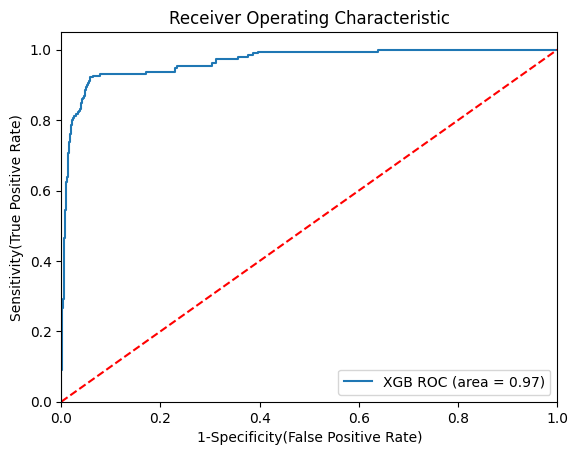

In [37]:
## Plot ROC AUC Curve
from sklearn.metrics import roc_auc_score,roc_curve
plt.figure()

# Add the models to the list that you want to view on the ROC plot
auc_models = [
{
    'label':'XGB',
    'model':XGBClassifier(booster='gbtree', learning_rate=0.1, max_depth=8, n_estimators=100, colsample_bytree=0.8),
    'auc':roc_auc_score(y_test,model.predict_proba(X_test)[:,1])
},

]
# create loop through all model
for algo in auc_models:
    model = algo['model'] # select the model
    model.fit(X_train, y_train) # train the model
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (algo['label'], algo['auc']))
# Custom settings for the plot
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig("auc.png")
plt.show()